In [1]:
import pandas as pd
import geopandas as gpd
import rasterio
import requests
import zipfile
import io
import os
import numpy as np
import shutil
from shapely.geometry import Point

In [2]:

def load_data_from_url(url, zipped=False, filepath=None, **kwargs):
    """
    Extracts and returns raw data from a URL.

    Parameters:
    url : str
        The URL of the file to be extracted.
    zipped : bool, optional
        If True, the file is expected to be inside a zip file. Default is False.
    filepath : str, optional
        If zipped is True, this is the path to the file inside the archive.
    **kwargs :
        Additional arguments passed to the appropriate reader function 
        (e.g., pd.read_csv, pd.read_excel, gpd.read_file, rasterio.open)

    Returns:
    data : DataFrame, GeoDataFrame, or rasterio.DatasetReader
    """
    def detect_file_type(path):
        ext = os.path.splitext(path.lower())[1]
        if ext in ['.csv']: return 'csv'
        if ext in ['.txt']: return 'txt'
        elif ext in ['.xls']: return 'xls'
        elif ext in ['.xlsx']: return 'xlsx'
        elif ext in ['.shp', '.geojson', '.gpkg', '.json', '.kml']: return 'vector'
        elif ext in ['.tif', '.tiff']: return 'raster'
        else: return 'unknown'

    response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    if response.status_code != 200:
        response.raise_for_status()

    if not zipped:
        file_type = detect_file_type(url)
        buffer = io.BytesIO(response.content)

        if file_type == 'csv' or file_type == 'txt':
            data = pd.read_csv(buffer, low_memory=False, **kwargs)
        elif file_type == 'xls':
            data = pd.read_excel(buffer, engine='xlrd', **kwargs)
        elif file_type == 'xlsx':
            data = pd.read_excel(buffer, engine='openpyxl', **kwargs)
        elif file_type == 'vector':
            data = gpd.read_file(buffer, **kwargs).to_crs(saws_crs)
        elif file_type == 'raster':
            data = rasterio.open(buffer, **kwargs)
        else: # fallback on csv
            try:
                data = pd.read_csv(buffer, low_memory=False, **kwargs) 
            except:
                raise ValueError(f"Could not download data from this URL. Please check URL and try again.")

    else:
        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
            if filepath is None:
                raise ValueError("Must specify 'filepath' within ZIP archive.")
            file_type = detect_file_type(filepath)

            try:
                with zip_file.open(filepath) as file:
                    if file_type == 'csv':
                        data = pd.read_csv(file, low_memory=False, **kwargs)
                    elif file_type == 'xls':
                        data = pd.read_excel(file, engine='xlrd', **kwargs)
                    elif file_type == 'xlsx':
                        data = pd.read_excel(file, engine='openpyxl', **kwargs)
                    elif file_type in ['vector', 'raster']:
                        raise NotImplementedError("Shapefiles and rasters require extraction.")
            except:
                zip_file.extractall('extracted_data')
                full_path = os.path.abspath(os.path.join('extracted_data', filepath))
                if file_type == 'csv':
                    data = pd.read_csv(full_path, low_memory=False, **kwargs)
                elif file_type == 'xls':
                    data = pd.read_excel(full_path, engine='xlrd', **kwargs)
                elif file_type == 'xlsx':
                    data = pd.read_excel(full_path, engine='openpyxl', **kwargs)
                elif file_type == 'vector':
                    data = gpd.read_file(full_path, **kwargs).to_crs(saws_crs)
                elif file_type == 'raster':
                    data = rasterio.open(full_path, **kwargs)
                shutil.rmtree('extracted_data')

    return data


def lat_long_to_point(df, lat_col, long_col):
    
    """
    This function takes a DataFrame with lat/long columns stored as floats
    and converts it into a GeoDataFrame with a point geometry.

    Arguments:
    df : DataFrame
        The DataFrame to be converted.
    lat_col : str
        The name of the column containing latitude values.
    long_col : str
        The name of the column containing longitude values.

    Returns:
    df : GeoDataFrame
        The modified DataFrame as a GeoDataFrame with point geometry.
    """

    df_geo = [Point(lon, lat) for lon, lat in zip(df[long_col], df[lat_col])]
    df = gpd.GeoDataFrame(df, geometry=df_geo, crs = 'EPSG:4326')
    df = df.to_crs(saws_crs)
    
    return df


In [3]:
data_url = 'https://www.sciencebase.gov/catalog/file/get/58937228e4b0fa1e59b73361?f=__disk__5a%2Fae%2F1a%2F5aae1aa25f84b94737628e43ef82e34f6897a63b'

data=load_data_from_url(data_url, zipped=True, filepath='Major_Ions.csv')
print(data.head())


  sourceID  unique_site_ID samp_id  proprietary_data state_alpha fips_cd  \
0    AZDEQ  AZDEQ-az000779     NaN                 0          AZ   04021   
1    AZDEQ  AZDEQ-az001146     NaN                 0          AZ   04013   
2    AZDEQ  AZDEQ-az002056     NaN                 0          AZ   04021   
3    AZDEQ  AZDEQ-az002153     NaN                 0          AZ   04021   
4    AZDEQ  AZDEQ-az006219     NaN                 0          AZ   04013   

  county_nm  dec_lat_va  dec_long_va location_flag  ...  \
0     Pinal   32.938241  -111.936083           2.0  ...   
1  Maricopa   33.005930  -112.676581           2.0  ...   
2     Pinal   32.676461  -111.516639           2.0  ...   
3     Pinal   33.065584  -111.975132           2.0  ...   
4  Maricopa   33.518722  -113.069351           2.0  ...   

   model_pp_Anhydrite_closed_16x  model_pp_Barite_closed_16x  \
0                            0.0                         0.0   
1                            0.0                         0.0

In [4]:
# Only include samples where TDS_mgL is greater than or equal to 1000
filtered_data = data[data['TDS_mgL'] >= 1000]

num_rows_total = len(data)  # total rows before filtering
num_rows_filtered = len(filtered_data)  # rows after filtering
num_rows_excluded = num_rows_total - num_rows_filtered

print("Number of rows in original data:", num_rows_total)
print("Number of rows in filtered data (TDS >= 1000 mg/L):", num_rows_filtered)
print("Number of rows excluded (TDS < 1000 mg/L):", num_rows_excluded)

Number of rows in original data: 123699
Number of rows in filtered data (TDS >= 1000 mg/L): 23454
Number of rows excluded (TDS < 1000 mg/L): 100245


In [5]:
filtered_data2 = filtered_data[filtered_data['model_pct_err'].abs() <= 10]

num_rows_filtered2 = len(filtered_data2)  # rows after filtering
num_rows_excluded2 = num_rows_filtered - num_rows_filtered2

print("Number of rows in filtered data (model_pct_err.abs() <= 10):", num_rows_filtered2)
print("Number of rows excluded (model_pct_err.abs() >= 10):", num_rows_excluded2)

Number of rows in filtered data (model_pct_err.abs() <= 10): 16706
Number of rows excluded (model_pct_err.abs() >= 10): 6748


In [6]:
mask = (
    (filtered_data2['well_depth_ft'].notna() | filtered_data2['well_depth2_ft'].notna()) &
    (filtered_data2['Temp_C'].notna() | filtered_data2['model_temp_c'].notna()) &
    (filtered_data2['ph'].notna() | filtered_data2['model_pH'].notna()) &
    filtered_data2['Alk_mgL'].notna() &
    filtered_data2['Si_mgL'].notna()
)
 
filtered_data3 = filtered_data2[mask]
num_rows_filtered2 = len(filtered_data2)
num_rows_filtered3 = len(filtered_data3)
num_rows_excluded3 = num_rows_filtered2 - num_rows_filtered3

print("Remaining rows after removing samples with missing key parameters:", num_rows_filtered3)
print("Number of rows excluded due to missing key parameters:", num_rows_excluded3)


Remaining rows after removing samples with missing key parameters: 14943
Number of rows excluded due to missing key parameters: 1763


In [7]:
# Get the indices of the two rows with highest silica (Si_mgL)
top_two_indices = filtered_data3.sort_values(by='Si_mgL', ascending=False).head(2).index

# Drop those two rows from DataFrame
filtered_data_final = filtered_data3.drop(top_two_indices)

print("Excluded rows with anomalously high silica values.")
print(f"Remaining rows after exclusion: {len(filtered_data_final)}")
print("Columns of final DataFrame:")
print(filtered_data_final.columns.tolist())

Excluded rows with anomalously high silica values.
Remaining rows after exclusion: 14941
Columns of final DataFrame:
['sourceID', 'unique_site_ID', 'samp_id', 'proprietary_data', 'state_alpha', 'fips_cd', 'county_nm', 'dec_lat_va', 'dec_long_va', 'location_flag', 'elevation_dem', 'well_depth_ft', 'well_depth2_ft', 'well_depth2_ft_flag', 'hole_depth_va', 'top_of_screen_va', 'bot_of_screen_va', 'csng_bottom_max_va', 'preferred_max_depth', 'preferred_min_depth', 'site_use', 'water_use', 'BGW_region_name', 'principal_aq', 'princ_aq_method', 'samp_start_dt', 'well_yield', 'WL_ft', 'WL_ft_desc', 'WL_ft_flag', 'Ag_ugL', 'Ag_ugL_desc', 'Ag_ugL_flag', 'Al_ugL', 'Al_ugL_desc', 'Al_ugL_flag', 'Alk_mgL', 'Alk_mgL_desc', 'Alk_mgL_flag', 'As_ugL', 'As_ugL_desc', 'As_ugL_flag', 'B_ugL', 'B_ugL_desc', 'B_ugL_flag', 'Ba_ugL', 'Ba_ugL_desc', 'Ba_ugL_flag', 'Be_ugL', 'Be_ugL_desc', 'Be_ugL_flag', 'Br_mgL', 'Br_mgL_desc', 'Br_mgL_flag', 'Ca_mgL', 'Ca_mgL_desc', 'Ca_mgL_flag', 'Cd_ugL', 'Cd_ugL_desc', 'Cd_

In [8]:
#################### TESTING FILTERING STATS ####################

import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import requests
import zipfile
import io
import os
import shutil
from shapely.geometry import Point



df = filtered_data_final.copy()
print(df.columns)


# Define ions by group

cations = ['model_Ba_molL', 'model_Ca_molL', 'model_Fe_molL', 'model_K_molL',
           'model_Li_molL', 'model_Mg_molL', 'model_Mn_molL', 'model_Na_molL', 'model_Sr_molL']
# Include Fe2+ as cation

anions = ['model_Br_molL', 'model_Cl_molL', 'model_C_molL', 'model_SO4_molL']  # Treat model_C as HCO3-

neutral_ions = ['model_B_molL', 'model_Si_molL']  # assumed neutral species

# Charges dictionary for equivalent calculation (charge per mole)
charges = {
    'model_Ba_molL': 2,
    'model_Ca_molL': 2,
    'model_Fe_molL': 2,
    'model_K_molL': 1,
    'model_Li_molL': 1,
    'model_Mg_molL': 2,
    'model_Mn_molL': 2,
    'model_Na_molL': 1,
    'model_Sr_molL': 2,
    'model_Br_molL': 1,
    'model_Cl_molL': 1,
    'model_C_molL': 1,
    'model_SO4_molL': 2
}

# --- Calculate equivalents for cations and anions ---

for ion in cations + anions:
    df[ion + '_eq'] = df[ion] * charges[ion]

# --- Calculate totals ---

df['total_cations_eq'] = df[[c + '_eq' for c in cations]].sum(axis=1)
df['total_anions_eq'] = df[[a + '_eq' for a in anions]].sum(axis=1)

# Total ions in mol/L from all charged equivalents converted back to mol/L plus neutral ions
    
df['total_ion_molL'] = (
    df[[ion + '_eq' for ion in cations + anions]].div(
        [charges[i] for i in cations + anions], axis=1
    ).sum(axis=1)
    + df[neutral_ions].sum(axis=1)
)

# --- Calculate fractions ---

# For ions belonging to cations and anions, fraction based on total equivalents
for ion in cations:
    df[ion + '_frac'] = np.where(df['total_cations_eq'] != 0,
                                df[ion + '_eq'] / df['total_cations_eq'], 
                                np.nan)

for ion in anions:
    df[ion + '_frac'] = np.where(df['total_anions_eq'] != 0,
                                df[ion + '_eq'] / df['total_anions_eq'], 
                                np.nan)

# For neutral ions (B, Si), fraction based on total ions in mol/L (including neutral)
for ion in neutral_ions:
    df[ion + '_frac'] = np.where(df['total_ion_molL'] != 0,
                                df[ion] / df['total_ion_molL'], 
                                np.nan)

# --- Log10 transform TDS ---

df['TDS_log10'] = np.log10(df['model_TDS_mgL'])

# --- Select only requested columns in the new df_ions DataFrame ---

frac_columns = [ion + '_frac' for ion in cations + anions + neutral_ions]
selected_columns = frac_columns + ['TDS_log10'] + ['well_depth_ft']

df_ions = df[selected_columns].copy()

# Columns to use for clustering (exclude water depth)
cluster_cols = [
    'model_Ca_molL_frac',
    'model_C_molL_frac',
    'model_Mg_molL_frac',
    'model_SO4_molL_frac',
    'model_Na_molL_frac',
    'model_Cl_molL_frac',
    'model_K_molL_frac',
    'model_pH',
    'model_Si_molL_frac',
    'model_temp_c',
    'TDS_log10'            # Log10 TDS for clustering
]

# Columns to include in stats (includes original TDS and water depth)
stat_cols = [
    'model_Ca_molL_frac',
    'model_C_molL_frac',
    'model_Mg_molL_frac',
    'model_SO4_molL_frac',
    'model_Na_molL_frac',
    'model_Cl_molL_frac',
    'model_K_molL_frac',
    'model_pH',
    'model_Si_molL_frac',
    'model_temp_c',
    'model_TDS_mgL',       # Original TDS for stats
    'bot_of_screen_va'        # Water depth for stats (not used in clustering)
]

# Filter data to rows without NaNs in clustering OR stats columns
needed_cols = cluster_cols + ['model_TDS_mgL', 'bot_of_screen_va']
df_filtered = df[needed_cols].replace([np.inf, -np.inf], np.nan).dropna()

# Prepare X for clustering
X = df_filtered[cluster_cols].values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels for stats
df_filtered = df_filtered.copy()
df_filtered['Cluster'] = cluster_labels.astype(str)

# Calculate mean and std by cluster for stats columns
grouped_stats = df_filtered.groupby('Cluster')[stat_cols].agg(['mean', 'std'])

print("Cluster statistics including water depth:")
print(grouped_stats)

grouped_stats.to_csv('cluster_stats_with_depth.csv')


/home/anne/miniconda3/envs/watertap-flex/lib/python3.11/site-packages/seaborn/_statistics.py:32: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.stats import gaussian_kde


Index(['sourceID', 'unique_site_ID', 'samp_id', 'proprietary_data',
       'state_alpha', 'fips_cd', 'county_nm', 'dec_lat_va', 'dec_long_va',
       'location_flag',
       ...
       'model_pp_Anhydrite_closed_16x', 'model_pp_Barite_closed_16x',
       'model_pp_Calcite_closed_16x', 'model_pp_Celestite_closed_16x',
       'model_pp_Chalcedony_closed_16x', 'model_pp_Gypsum_closed_16x',
       'model_pp_Halite_closed_16x', 'model_pp_Ferrihydrite_closed_16x',
       'model_pp_mgL_closed_16x', 'model_os_p_closed_16x'],
      dtype='object', length=376)
Cluster statistics including water depth:
        model_Ca_molL_frac           model_C_molL_frac            \
                      mean       std              mean       std   
Cluster                                                            
0                 0.401847  0.145445          0.280286  0.159818   
1                 0.131222  0.113831          0.216521  0.136354   
2                 0.052348  0.063181          0.521265  0.227

In [9]:
############### PROCESSING SPECIFIC FOR OUR CASES AND CLUSTERING ####################
# List of state abbreviations you want to keep
states_to_keep = ["FL", "CA", "TX", "AZ", "NM"]

# Filter DataFrame to only keep those states
data_by_state = filtered_data_final[filtered_data_final['state_alpha'].isin(states_to_keep)]
print(data_by_state.columns.tolist())
data_by_state.to_csv('data_states_processed_before.csv', index=False)
data_by_state = data_by_state[data_by_state['well_depth_ft'] < 3000].copy()



print(f"Remaining rows after keeping only {states_to_keep}: {len(data_by_state)}")
data_CA = data_by_state[data_by_state['state_alpha'] == 'CA']
print(f"Filtered data for California: {len(data_CA)}")
data_FL = data_by_state[data_by_state['state_alpha'] == 'FL']
print(f"Filtered data for Florida: {len(data_FL)}")
data_TX = data_by_state[data_by_state['state_alpha'] == 'TX']
print(f"Filtered data for Texas: {len(data_TX)}")
data_AZ = data_by_state[data_by_state['state_alpha'] == 'AZ']
print(f"Filtered data for Arizona: {len(data_AZ)}")
data_NM = data_by_state[data_by_state['state_alpha'] == 'NM']
print(f"Filtered data for New Mexico: {len(data_NM)}")

data_by_state.to_csv('data_states_processed.csv', index=False)

['sourceID', 'unique_site_ID', 'samp_id', 'proprietary_data', 'state_alpha', 'fips_cd', 'county_nm', 'dec_lat_va', 'dec_long_va', 'location_flag', 'elevation_dem', 'well_depth_ft', 'well_depth2_ft', 'well_depth2_ft_flag', 'hole_depth_va', 'top_of_screen_va', 'bot_of_screen_va', 'csng_bottom_max_va', 'preferred_max_depth', 'preferred_min_depth', 'site_use', 'water_use', 'BGW_region_name', 'principal_aq', 'princ_aq_method', 'samp_start_dt', 'well_yield', 'WL_ft', 'WL_ft_desc', 'WL_ft_flag', 'Ag_ugL', 'Ag_ugL_desc', 'Ag_ugL_flag', 'Al_ugL', 'Al_ugL_desc', 'Al_ugL_flag', 'Alk_mgL', 'Alk_mgL_desc', 'Alk_mgL_flag', 'As_ugL', 'As_ugL_desc', 'As_ugL_flag', 'B_ugL', 'B_ugL_desc', 'B_ugL_flag', 'Ba_ugL', 'Ba_ugL_desc', 'Ba_ugL_flag', 'Be_ugL', 'Be_ugL_desc', 'Be_ugL_flag', 'Br_mgL', 'Br_mgL_desc', 'Br_mgL_flag', 'Ca_mgL', 'Ca_mgL_desc', 'Ca_mgL_flag', 'Cd_ugL', 'Cd_ugL_desc', 'Cd_ugL_flag', 'Cl_mgL', 'Cl_mgL_desc', 'Cl_mgL_flag', 'Co_ugL', 'Co_ugL_desc', 'Co_ugL_flag', 'CO3_mgL', 'CO3_mgL_desc',

Features used for clustering: ['model_Ca_molL_frac', 'model_Mg_molL_frac', 'model_Na_molL_frac', 'model_K_molL_frac', 'model_Cl_molL_frac', 'model_SO4_molL_frac', 'model_C_molL_frac', 'model_Si_molL_frac', 'TDS_log10', 'model_pH', 'model_temp_c']
model_Ca_molL_frac     0
model_Mg_molL_frac     0
model_Na_molL_frac     0
model_K_molL_frac      0
model_Cl_molL_frac     0
model_SO4_molL_frac    0
model_C_molL_frac      0
model_Si_molL_frac     0
TDS_log10              0
model_pH               0
model_temp_c           0
dtype: int64
Number of NaN values in model_C_molL: 0
Number of zero values in model_C_molL: 6


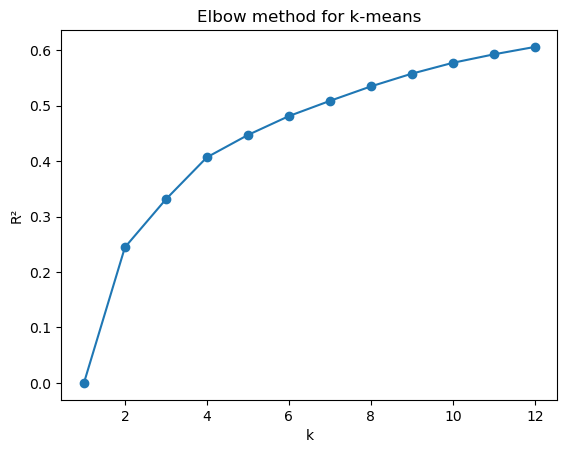

k=2, silhouette score=0.241
k=3, silhouette score=0.197
k=4, silhouette score=0.194
k=5, silhouette score=0.194
k=6, silhouette score=0.186
k=7, silhouette score=0.168
k=8, silhouette score=0.168
k=9, silhouette score=0.163
k=10, silhouette score=0.168
k=11, silhouette score=0.167
k=12, silhouette score=0.168


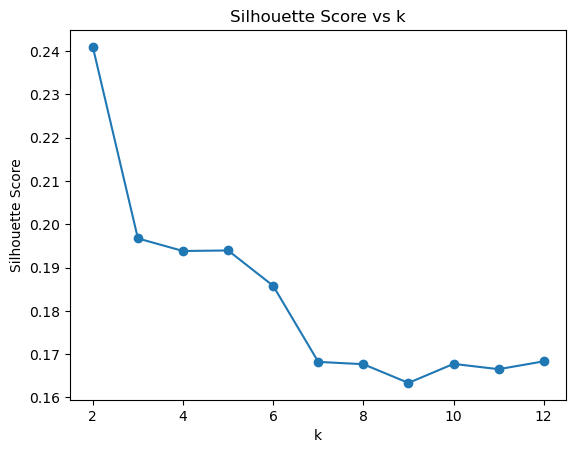

In [11]:
################### USGS data processing AND CLUSTERING ##########################
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

df = data_by_state.copy()


# === Stage 1: Ion & TDS Processing ===
# Define cation and anion columns in mol/L
cations = ['model_Ca_molL', 'model_Mg_molL', 'model_Na_molL', 'model_K_molL']
anions = ['model_Cl_molL', 'model_SO4_molL', 'model_C_molL']       # treating C as bicarbonate (HCO3-)
silica_col = 'model_Si_molL'
dissolved_solids_col = 'model_TDS_mgL'

# Charges for equivalent calculations
charges = {
    'model_Ca_molL': 2,
    'model_Mg_molL': 2,
    'model_Na_molL': 1,
    'model_K_molL': 1,
    'model_Cl_molL': 1,
    'model_SO4_molL': 2,
    'model_C_molL': 1 # treating C as bicarbonate (HCO3-)
}

# Calculate equivalents for all major ions (mol/L × charge = eq/L)
for ion in cations + anions:
    df[ion + '_eq'] = df[ion] * charges[ion]

# Totals
df['total_cations_eq'] = df[[c + '_eq' for c in cations]].sum(axis=1)
df['total_anions_eq']  = df[[a + '_eq' for a in anions]].sum(axis=1)


# Fractions
for ion in cations:
    df[ion + '_frac'] = df[ion + '_eq'] / df['total_cations_eq']
for ion in anions:
    df[ion + '_frac'] = df[ion + '_eq'] / df['total_anions_eq']

# Print just the new columns created
#new_cols = [ion + '_eq' for ion in cations + anions] + ['total_cations_eq', 'total_anions_eq']
#print(df[new_cols].head())

# Silica fraction
df['total_ion_molL'] = (
    df[[ion + '_eq' for ion in cations + anions]]
    .div([charges[i] for i in cations + anions], axis=1)
    .sum(axis=1)
)
df['model_Si_molL_frac'] = df['model_Si_molL'] / df['total_ion_molL']

# Log transform TDS
df['TDS_log10'] = np.log10(df[dissolved_solids_col])


# === Stage 2: Data Normalization ===
# Prepare dataframe for clustering
untouched = ['model_pH', 'model_temp_c']
features = [col for col in df.columns if col.endswith('_frac')] + ['TDS_log10'] + untouched
X = df[features]
print("Features used for clustering:", X.columns.tolist())

# Count NaNs in each column
print(df[features].isna().sum())

# Count number of NaN values
num_nan = df['model_C_molL'].isna().sum()

# Count number of zero values (excluding NaNs)
num_zero = (df['model_C_molL'] == 0).sum()

print(f"Number of NaN values in model_C_molL: {num_nan}")
print(f"Number of zero values in model_C_molL: {num_zero}")

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# R² vs k
K_range = range(1, 13)
r2_values = []
tot_ss = np.sum((X_scaled - X_scaled.mean(axis=0)) ** 2)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    between_ss = tot_ss - km.inertia_
    r2_values.append(between_ss / tot_ss)

plt.plot(K_range, r2_values, marker='o')
plt.xlabel('k')
plt.ylabel('R²')
plt.title('Elbow method for k-means')
plt.show()

# Final k=4 (example)
k_optimal = 4
km_final = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
df['Cluster'] = km_final.fit_predict(X_scaled)

# Save results
#df.to_csv("geochem_clusters_with_metadata.csv", index=False)

sil_scores = []
K_range = range(2, 13)  # silhouette score not defined for k=1

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, cluster_labels)
    sil_scores.append(score)
    print(f"k={k}, silhouette score={score:.3f}")

# Plot the silhouette scores
plt.figure()
plt.plot(list(K_range), sil_scores, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k')
plt.show()

In [12]:
k_optimal = 4  # Found via elbow method and same as what USGS found
km_final = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
df['Cluster'] = km_final.fit_predict(X_scaled)

print(df['Cluster'].value_counts())

cluster_means = pd.DataFrame(
    km_final.cluster_centers_, columns=X.columns
)
print(cluster_means)


Cluster
3    1345
2    1329
1    1067
0     992
Name: count, dtype: int64
   model_Ca_molL_frac  model_Mg_molL_frac  model_Na_molL_frac  \
0           -0.438671           -0.209820            0.400094   
1            1.084098            0.962976           -1.155865   
2           -0.970614           -1.017793            1.113845   
3            0.421944            0.396050           -0.478072   

   model_K_molL_frac  model_Cl_molL_frac  model_SO4_molL_frac  \
0          -0.048809            1.113311            -0.477601   
1          -0.285916           -1.070569             1.385040   
2          -0.040281            0.016811            -0.297959   
3           0.302359            0.012381            -0.452115   

   model_C_molL_frac  model_Si_molL_frac  TDS_log10  model_pH  model_temp_c  
0          -0.879485           -0.595357   1.136482 -0.143248      0.227279  
1          -0.452933            0.087688   0.110266 -0.347449     -0.602596  
2           0.394574           -0.062375

In [13]:
import seaborn as sns
# Attach cluster labels to your original df
df['Cluster'] = km_final.labels_


# Calculate means (and std) for each cluster
cluster_profile = df.groupby('Cluster')[features].agg(['mean', 'std'])

print(cluster_profile)

# Number of features to plot
features = list(features)
if 'well_depth_ft' not in features:
    features.append('well_depth_ft')
num_features = len(features)

# 1. Get number of points in each cluster as a dictionary
cluster_counts = df['Cluster'].value_counts().sort_index().to_dict()
cluster_labels = [f"{cluster}\n(n={cluster_counts.get(cluster,0)})" for cluster in sorted(cluster_counts)]

# 2. Set up a 3-column grid for the plots
num_cols = 3
num_rows = int(np.ceil(num_features / num_cols))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(7*num_cols, 4*num_rows), constrained_layout=True)

# 3. Flatten axes for iteration
axes = axes.flatten() if num_features > 1 else [axes]

for i, feature in enumerate(features):
    ax = axes[i]
    sns.boxplot(data=df, x='Cluster', y=feature, ax=ax)
    ax.set_xticklabels(cluster_labels)
    ax.set_title(f'{feature} by Cluster')

# 4. Remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])


# Save to a single file (e.g., PDF for multi-page, or PNG for single image)
plt.savefig('usgs/boxplots/all_features_by_cluster.png', dpi=300)

plt.close(fig)

        model_Ca_molL_frac           model_Mg_molL_frac            \
                      mean       std               mean       std   
Cluster                                                             
0                 0.157789  0.113303           0.122226  0.081519   
1                 0.467011  0.173551           0.263185  0.099220   
2                 0.049763  0.057395           0.024869  0.034834   
3                 0.332675  0.135986           0.194922  0.094089   

        model_Na_molL_frac           model_K_molL_frac            \
                      mean       std              mean       std   
Cluster                                                            
0                 0.711747  0.162903          0.008238  0.009035   
1                 0.264740  0.167092          0.005064  0.004600   
2                 0.917011  0.085851          0.008357  0.008701   
3                 0.459445  0.155828          0.012958  0.021273   

        model_Cl_molL_frac            .

/tmp/ipykernel_1137592/1142278644.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_labels)
/tmp/ipykernel_1137592/1142278644.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_labels)
/tmp/ipykernel_1137592/1142278644.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_labels)
/tmp/ipykernel_1137592/1142278644.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_labels)
/tmp/ipykernel_1137592/1142278644.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.se

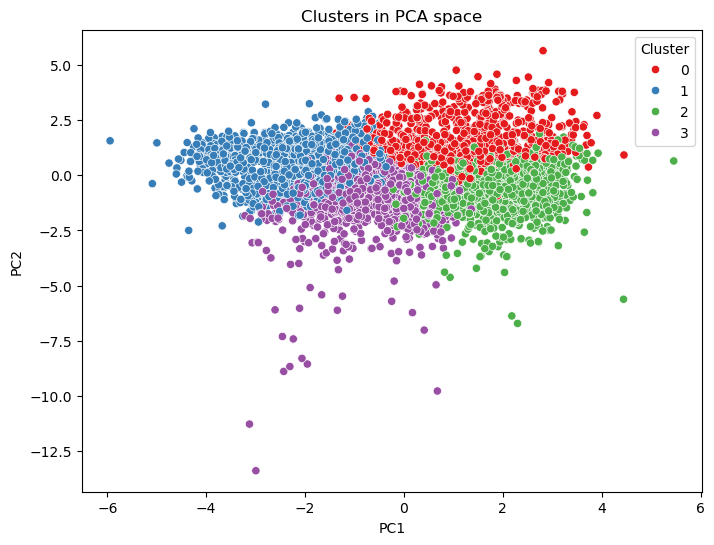

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['Cluster'], palette='Set1')
plt.title('Clusters in PCA space')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


In [ ]:
################ STATE-WISE INITIAL ANALYSES ######################

import matplotlib.pyplot as plt

states = df['state_alpha'].unique()
n_states = len(states)

# Prepare figures: one for all elbow plots, one for all silhouette plots
fig_elbow, axes_elbow = plt.subplots(n_states, 1, figsize=(7, 4*n_states), constrained_layout=True)
fig_sil, axes_sil = plt.subplots(n_states, 1, figsize=(7, 4*n_states), constrained_layout=True)

# If only one state, axes is not a list--wrap it
if n_states == 1:
    axes_elbow = [axes_elbow]
    axes_sil = [axes_sil]

for idx, state in enumerate(states):
    X_state = X[df['state_alpha'] == state]
    print(f"\nState: {state}, Shape: {X_state.shape}")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_state)
    
    # Elbow method
    r2_values = []
    k_max = min(12, len(X_state) - 1)
    elbow_k_range = range(1, k_max+1)
    tot_ss = np.sum((X_scaled - X_scaled.mean(axis=0)) ** 2)
    for k in elbow_k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        km.fit(X_scaled)
        between_ss = tot_ss - km.inertia_
        r2_values.append(between_ss / tot_ss)
    axes_elbow[idx].plot(list(elbow_k_range), r2_values, marker='o')
    axes_elbow[idx].set_xlabel('k')
    axes_elbow[idx].set_ylabel('R²')
    axes_elbow[idx].set_title(f'Elbow: {state}')

    # Silhouette scores
    sil_scores = []
    sil_k_range = range(2, min(13, len(X_state)))
    for k in sil_k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        sil_scores.append(score)
        print(f"State={state}, k={k}, silhouette score={score:.3f}")
    axes_sil[idx].plot(list(sil_k_range), sil_scores, marker='o')
    axes_sil[idx].set_xlabel('k')
    axes_sil[idx].set_ylabel('Silhouette Score')
    axes_sil[idx].set_title(f'Silhouette: {state}')

# Save both figures
fig_elbow.savefig("usgs/states_elbow.png", dpi=300)
plt.close(fig_elbow)

fig_sil.savefig("usgs/states_silhouette.png", dpi=300)
plt.close(fig_sil)



State: NM, Shape: (159, 11)
State=NM, k=2, silhouette score=0.331
State=NM, k=3, silhouette score=0.278
State=NM, k=4, silhouette score=0.284
State=NM, k=5, silhouette score=0.284
State=NM, k=6, silhouette score=0.206
State=NM, k=7, silhouette score=0.264
State=NM, k=8, silhouette score=0.296
State=NM, k=9, silhouette score=0.252
State=NM, k=10, silhouette score=0.313
State=NM, k=11, silhouette score=0.240
State=NM, k=12, silhouette score=0.230

State: TX, Shape: (2327, 11)
State=TX, k=2, silhouette score=0.277
State=TX, k=3, silhouette score=0.265
State=TX, k=4, silhouette score=0.210
State=TX, k=5, silhouette score=0.218
State=TX, k=6, silhouette score=0.204
State=TX, k=7, silhouette score=0.205
State=TX, k=8, silhouette score=0.195
State=TX, k=9, silhouette score=0.196
State=TX, k=10, silhouette score=0.196
State=TX, k=11, silhouette score=0.194
State=TX, k=12, silhouette score=0.184

State: FL, Shape: (376, 11)
State=FL, k=2, silhouette score=0.439
State=FL, k=3, silhouette score=

In [16]:
state_k_map = {
    "NM": 4,
    "TX": 3,
    "FL": 5,
    "CA": 5,
    "AZ": 6
}

print("Features:", features)

results = {}
output_folder = "usgs/boxplots"
# FIRST LOOP: Cluster per state and collect results
for state, k_opt in state_k_map.items():
    print(f"\n--- Analyzing {state} (k={k_opt}) ---")
    df_state = df[df['state_alpha'] == state].copy()
    X_state = df_state[features]
    
    # Ensure clean data
    X_state = X_state.replace([np.inf, -np.inf], np.nan).dropna()
    df_state = df_state.loc[X_state.index]
    
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_state)

    # Perform k-means
    km = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
    df_state['Cluster'] = km.fit_predict(X_scaled)

    # (Optional) Show cluster sizes and means for this state
    print(df_state['Cluster'].value_counts())
    print(df_state.groupby('Cluster')[features].mean())

    # Save or store result for later use
    results[state] = df_state
    # df_state.to_csv(f"geochem_clusters_{state}.csv", index=False)



# SECOND LOOP: Generate and save summary boxplots per state

for state, df_state in results.items():
    # Add 'well_depth_ft' if not already in features
    plot_features = list(features)
    if 'well_depth_ft' not in plot_features:
        plot_features.append('well_depth_ft')
    n_features = len(plot_features)
    n_cols = 3  # Adjust as needed for aesthetics
    n_rows = int(np.ceil(n_features / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()


    for idx, feature in enumerate(features):
        ax = axes[idx]
        sns.boxplot(
            x='Cluster',
            y=feature,
            data=df_state,
            ax=ax
        )
        # Explicitly set ticks and labels
        ax.set_xticklabels(cluster_labels)
        ax.set_title(f"{feature} by Cluster in {state}")
    # Hide any unused axes
    for i in range(len(features), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    # Save in boxplots folder
    plt.savefig(os.path.join(output_folder, f"Cluster_Boxplots_{state}.png"), dpi=300)
    plt.close(fig)  # Free memory

    print(f"{state} saved as Cluster_Boxplots_{state}.png")


Features: ['model_Ca_molL_frac', 'model_Mg_molL_frac', 'model_Na_molL_frac', 'model_K_molL_frac', 'model_Cl_molL_frac', 'model_SO4_molL_frac', 'model_C_molL_frac', 'model_Si_molL_frac', 'TDS_log10', 'model_pH', 'model_temp_c', 'well_depth_ft']

--- Analyzing NM (k=4) ---
Cluster
2    88
0    44
1    19
3     8
Name: count, dtype: int64
         model_Ca_molL_frac  model_Mg_molL_frac  model_Na_molL_frac  \
Cluster                                                               
0                  0.161829            0.065477            0.757982   
1                  0.168202            0.079924            0.720219   
2                  0.457670            0.165100            0.366704   
3                  0.443921            0.114439            0.431643   

         model_K_molL_frac  model_Cl_molL_frac  model_SO4_molL_frac  \
Cluster                                                               
0                 0.014712            0.682121             0.247010   
1                 0.03

/tmp/ipykernel_1137592/3484519230.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_labels)
/tmp/ipykernel_1137592/3484519230.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_labels)
/tmp/ipykernel_1137592/3484519230.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_labels)
/tmp/ipykernel_1137592/3484519230.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_labels)
/tmp/ipykernel_1137592/3484519230.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.se

NM saved as Cluster_Boxplots_NM.png


/tmp/ipykernel_1137592/3484519230.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_labels)
/tmp/ipykernel_1137592/3484519230.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_labels)
/tmp/ipykernel_1137592/3484519230.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_labels)
/tmp/ipykernel_1137592/3484519230.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_labels)
/tmp/ipykernel_1137592/3484519230.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.se

TX saved as Cluster_Boxplots_TX.png


/tmp/ipykernel_1137592/3484519230.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_labels)
/tmp/ipykernel_1137592/3484519230.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_labels)
/tmp/ipykernel_1137592/3484519230.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_labels)
/tmp/ipykernel_1137592/3484519230.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_labels)
/tmp/ipykernel_1137592/3484519230.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.se

FL saved as Cluster_Boxplots_FL.png


/tmp/ipykernel_1137592/3484519230.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_labels)
/tmp/ipykernel_1137592/3484519230.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_labels)
/tmp/ipykernel_1137592/3484519230.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_labels)
/tmp/ipykernel_1137592/3484519230.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_labels)
/tmp/ipykernel_1137592/3484519230.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.se

CA saved as Cluster_Boxplots_CA.png


/tmp/ipykernel_1137592/3484519230.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_labels)
/tmp/ipykernel_1137592/3484519230.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_labels)
/tmp/ipykernel_1137592/3484519230.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_labels)
/tmp/ipykernel_1137592/3484519230.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_labels)
/tmp/ipykernel_1137592/3484519230.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.se

AZ saved as Cluster_Boxplots_AZ.png
